In [ ]:
histopathology (histo): 조직병리학적 검사를 통해 확인된 진단
follow-up examination (follow_up): 추적 검사를 통해 확인된 진단
expert consensus (consensus): 전문가 합의를 통해 확인된 진단
confirmation by in-vivo confocal microscopy (confocal): 인체 내 현미경을 사용하여 확인된 진단

dx는 진단(diagnosis)을 의미
"dx":

(nv)    Melanocytic nevi (흑색종)                  멜라닌세포모반은 모반세포(점세포, nevus cell, nevomelanocyte)로 이루어진 양성 종양
(mel)   Melanoma (흑색종)                          악성 흑색종은 멜라닌 생성 세포로 구성된 피부 악성 신생물(암)
(bkl)   Benign keratosis-like lesions (양성 각화 유사 병변) 
(bcc)   Basal cell carcinoma (기저세포암)           기저세포 암종은 표피 및 그 부속기 기저부의 비각질화 세포에서 유래한 악성 종양
(akiec) Actinic keratoses (광선각화증)              광선 각화증이란 지속적인 햇빛 노출에 의해 피부에 인설이 동반된 분홍색 또는 적색의 반점이나 구진이 생기는 피부 병변
(vasc)  Vascular lesions (혈관병변)                 피부나 점막에 발생하는 혈관 관련 이상
(df)    Dermatofibroma (피부섬유종)                  진피의 섬유성 종양 모양의 결절.

dx_type은 진단의 유형을 나타냅니다. 각 진단이 어떻게 확인되었는지를 나타냅니다.
"dx_type":

(histo)      histo: 조직 검사 결과를 기반으로 한 진단                                            histopathological(조직학적)
(follow_up)  follow-up examination : 진단 후 추적 관찰                                         follow-up(후행, 추적)
(consensus)  expert consensus: 전문가 그룹의 의견을 바탕으로 한 합의 진단                         consensus(합의)
(confocal)   confirmation by in-vivo confocal microscopy : 조직 검사 대신 피부 조절 현미경 사용  confocal(공초점의)

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
from glob import glob
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, concatenate, Dense, BatchNormalization, Dropout
from keras import backend as K
import itertools

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [3]:
base_skin_dir = os.path.join('.','archive')
#print(base_skin_dir)  --> .\archive

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, 'HAM10000_images', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
imageid_path_dict
#for dirname, _, filenames in os.walk('./archive'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

{'ISIC_0024306': '.\\archive\\HAM10000_images\\ISIC_0024306.jpg',
 'ISIC_0024307': '.\\archive\\HAM10000_images\\ISIC_0024307.jpg',
 'ISIC_0024308': '.\\archive\\HAM10000_images\\ISIC_0024308.jpg',
 'ISIC_0024309': '.\\archive\\HAM10000_images\\ISIC_0024309.jpg',
 'ISIC_0024310': '.\\archive\\HAM10000_images\\ISIC_0024310.jpg',
 'ISIC_0024311': '.\\archive\\HAM10000_images\\ISIC_0024311.jpg',
 'ISIC_0024312': '.\\archive\\HAM10000_images\\ISIC_0024312.jpg',
 'ISIC_0024313': '.\\archive\\HAM10000_images\\ISIC_0024313.jpg',
 'ISIC_0024314': '.\\archive\\HAM10000_images\\ISIC_0024314.jpg',
 'ISIC_0024315': '.\\archive\\HAM10000_images\\ISIC_0024315.jpg',
 'ISIC_0024316': '.\\archive\\HAM10000_images\\ISIC_0024316.jpg',
 'ISIC_0024317': '.\\archive\\HAM10000_images\\ISIC_0024317.jpg',
 'ISIC_0024318': '.\\archive\\HAM10000_images\\ISIC_0024318.jpg',
 'ISIC_0024319': '.\\archive\\HAM10000_images\\ISIC_0024319.jpg',
 'ISIC_0024320': '.\\archive\\HAM10000_images\\ISIC_0024320.jpg',
 'ISIC_002

In [4]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\archive\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [6]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [8]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


<Axes: xlabel='cell_type'>

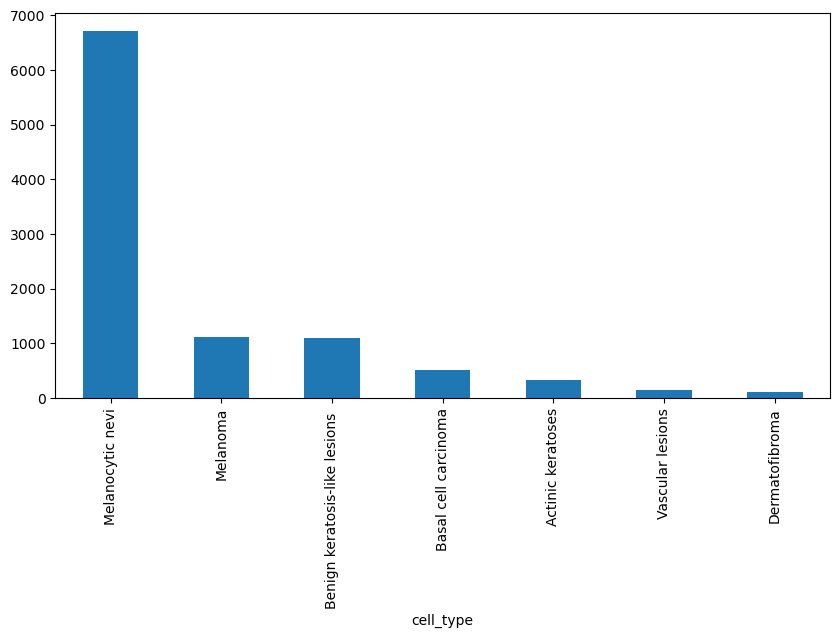

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
print(skin_df['dx'].value_counts())
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [25]:
from PIL import Image
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((80, 60))))

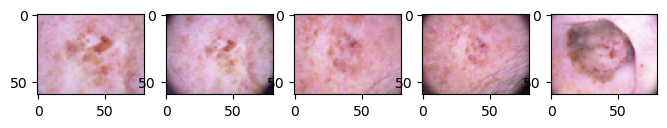

In [43]:
plt.figure(figsize=(8, 6))
for i in range(5):
  plt.subplot(1,5,i+1) # 행 하나, 열 다섯 개, 1로 시작하는 인덱스|
  plt.imshow(skin_df['image'][i])
plt.show()

In [27]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 151, 193], [191, 153, 194], [192, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 26], [29, 17, 36], [4..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 128, 139], [190, 133, 148], [196, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[23, 11, 18], [31, 16, 26], [50, 28, 39], [7..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\archive\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[137, 93, 116], [153, 108, 132], [169, 124, ..."


In [28]:
nv_skin_df = skin_df[skin_df['dx'] == 'bkl'] #6705
mel_skin_df = skin_df[skin_df['dx'] == 'mel'] #1113
bkl_skin_df = skin_df[skin_df['dx'] == 'bkl'] #1099
bcc_skin_df = skin_df[skin_df['dx'] == 'bcc'] #514
akiec_skin_df = skin_df[skin_df['dx'] == 'akiec'] #327
vasc_skin_df = skin_df[skin_df['dx'] == 'vasc'] #142
df_skin_df = skin_df[skin_df['dx'] == 'df'] #115
df_skin_df['image'].shape

(115,)

In [31]:
# Data Augmentation on train set 
import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,
        brightness_range=(0.8, 1.2) # 0.8배에서 1.2배
        )  # randomly flip images

In [56]:
df_skin_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'image'],
      dtype='object')

In [85]:
bcc_skin_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'image'],
      dtype='object')

In [75]:
# mel
# 1113
augmented_mel = pd.DataFrame(columns=mel_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성

multi = 3

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(mel_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = mel_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_mel.loc[i*multi + j] = augmented_metadata


# 결과 확인
augmented_mel.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,.\archive\HAM10000_images\ISIC_0025964.jpg,Melanoma,5,"[[[193.0, 156.0, 172.0], [197.0, 157.0, 175.0]..."
1,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,.\archive\HAM10000_images\ISIC_0025964.jpg,Melanoma,5,"[[[193.0, 174.0, 174.0], [196.0, 176.0, 176.0]..."
2,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,.\archive\HAM10000_images\ISIC_0025964.jpg,Melanoma,5,"[[[78.0, 67.0, 68.0], [78.0, 67.0, 68.0], [78...."
3,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,.\archive\HAM10000_images\ISIC_0030623.jpg,Melanoma,5,"[[[228.0, 201.0, 221.0], [228.0, 201.0, 219.0]..."
4,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,.\archive\HAM10000_images\ISIC_0030623.jpg,Melanoma,5,"[[[229.0, 200.0, 220.0], [229.0, 200.0, 220.0]..."


In [77]:
# augmented_bkl = pd.DataFrame(columns=bkl_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성
# 1099

augmented_bkl = pd.DataFrame(columns=bkl_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성

multi = 3

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(bkl_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = bkl_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_bkl.loc[i*multi + j] = augmented_metadata


# 결과 확인
augmented_bkl.head()

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
2  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
3  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
4  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   

                                         path                       cell_type  \
0  .\archive\HAM10000_images\ISIC_0027419.jpg  Benign keratosis-like lesions    
1  .\archive\HAM10000_images\ISIC_0027419.jpg  Benign keratosis-like lesions    
2  .\archive\HAM10000_images\ISIC_0027419.jpg  Benign keratosis-like lesions    
3  .\archive\HAM10000_images\ISIC_0025030.jpg  Benign keratosis-like lesions    
4  .\archive\HAM10000_images\ISIC_0025030.jpg  Benign keratosis-like lesions    

  cell_type_idx                                              image  
0             2  [[[223

In [89]:
# bcc
#514

augmented_bcc = pd.DataFrame(columns=bcc_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성

multi = 6

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(bcc_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = bcc_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_bcc.loc[i*multi + j] = augmented_metadata


# 결과 확인
augmented_bcc.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,.\archive\HAM10000_images\ISIC_0028155.jpg,Basal cell carcinoma,1,"[[[174.0, 149.0, 153.0], [191.0, 165.0, 169.0]..."
1,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,.\archive\HAM10000_images\ISIC_0028155.jpg,Basal cell carcinoma,1,"[[[255.0, 239.0, 242.0], [255.0, 239.0, 241.0]..."
2,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,.\archive\HAM10000_images\ISIC_0028155.jpg,Basal cell carcinoma,1,"[[[191.0, 162.0, 157.0], [189.0, 160.0, 156.0]..."
3,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,.\archive\HAM10000_images\ISIC_0028155.jpg,Basal cell carcinoma,1,"[[[245.0, 214.0, 213.0], [249.0, 217.0, 216.0]..."
4,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,.\archive\HAM10000_images\ISIC_0028155.jpg,Basal cell carcinoma,1,"[[[157.0, 134.0, 138.0], [191.0, 164.0, 166.0]..."


In [81]:
# akiec
# 327

augmented_akiec = pd.DataFrame(columns=akiec_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성

multi = 8

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(akiec_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = akiec_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_akiec.loc[i*multi + j] = augmented_metadata


# 결과 확인
augmented_akiec.head()

     lesion_id      image_id     dx dx_type   age     sex localization  \
0  HAM_0002644  ISIC_0029417  akiec   histo  80.0  female         neck   
1  HAM_0002644  ISIC_0029417  akiec   histo  80.0  female         neck   
2  HAM_0002644  ISIC_0029417  akiec   histo  80.0  female         neck   
3  HAM_0002644  ISIC_0029417  akiec   histo  80.0  female         neck   
4  HAM_0002644  ISIC_0029417  akiec   histo  80.0  female         neck   

                                         path          cell_type  \
0  .\archive\HAM10000_images\ISIC_0029417.jpg  Actinic keratoses   
1  .\archive\HAM10000_images\ISIC_0029417.jpg  Actinic keratoses   
2  .\archive\HAM10000_images\ISIC_0029417.jpg  Actinic keratoses   
3  .\archive\HAM10000_images\ISIC_0029417.jpg  Actinic keratoses   
4  .\archive\HAM10000_images\ISIC_0029417.jpg  Actinic keratoses   

  cell_type_idx                                              image  
0             0  [[[202.0, 163.0, 157.0], [209.0, 164.0, 155.0]...  
1       

In [86]:
# vasc
# 142

augmented_vasc = pd.DataFrame(columns=vasc_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성

multi = 14

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(vasc_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = vasc_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_vasc.loc[i*multi + j] = augmented_metadata


# 결과 확인
augmented_vasc.head()

     lesion_id      image_id    dx dx_type   age   sex     localization  \
0  HAM_0006889  ISIC_0031197  vasc   histo  20.0  male  upper extremity   
1  HAM_0006889  ISIC_0031197  vasc   histo  20.0  male  upper extremity   
2  HAM_0006889  ISIC_0031197  vasc   histo  20.0  male  upper extremity   
3  HAM_0006889  ISIC_0031197  vasc   histo  20.0  male  upper extremity   
4  HAM_0006889  ISIC_0031197  vasc   histo  20.0  male  upper extremity   

                                         path         cell_type cell_type_idx  \
0  .\archive\HAM10000_images\ISIC_0031197.jpg  Vascular lesions             6   
1  .\archive\HAM10000_images\ISIC_0031197.jpg  Vascular lesions             6   
2  .\archive\HAM10000_images\ISIC_0031197.jpg  Vascular lesions             6   
3  .\archive\HAM10000_images\ISIC_0031197.jpg  Vascular lesions             6   
4  .\archive\HAM10000_images\ISIC_0031197.jpg  Vascular lesions             6   

                                               image  
0  [[[2

In [87]:
# df
# 115

augmented_df = pd.DataFrame(columns=df_skin_df.columns)

multi = 20

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(df_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = df_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_df.loc[i*multi + j] = augmented_metadata

# 결과 확인
augmented_df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,.\archive\HAM10000_images\ISIC_0027008.jpg,Dermatofibroma,3,"[[[232.0, 181.0, 166.0], [232.0, 181.0, 167.0]..."
1,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,.\archive\HAM10000_images\ISIC_0027008.jpg,Dermatofibroma,3,"[[[205.0, 161.0, 152.0], [203.0, 158.0, 146.0]..."
2,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,.\archive\HAM10000_images\ISIC_0027008.jpg,Dermatofibroma,3,"[[[171.0, 133.0, 129.0], [169.0, 132.0, 129.0]..."
3,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,.\archive\HAM10000_images\ISIC_0027008.jpg,Dermatofibroma,3,"[[[205.0, 158.0, 155.0], [204.0, 155.0, 151.0]..."
4,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,.\archive\HAM10000_images\ISIC_0027008.jpg,Dermatofibroma,3,"[[[172.0, 129.0, 111.0], [186.0, 142.0, 125.0]..."


In [91]:
import pandas as pd
# nv       6705
# mel      1113
# bkl      1099
# bcc       514
# akiec     327
# vasc      142
# df        115
# skin_df와 augmented_df를 병합하여 새로운 DataFrame 생성
merged_df = pd.concat([skin_df, augmented_mel, augmented_bkl, augmented_bcc, augmented_akiec, augmented_vasc, augmented_df], ignore_index=True)

# 결과 확인
merged_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 151, 193], [191, 153, 194], [192, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 26], [29, 17, 36], [4..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 128, 139], [190, 133, 148], [196, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[23, 11, 18], [31, 16, 26], [50, 28, 39], [7..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\archive\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[137, 93, 116], [153, 108, 132], [169, 124, ..."


(10015, 11)

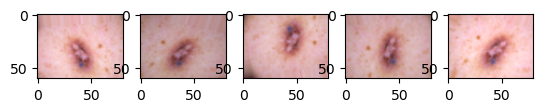

In [41]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.subplot(1,5,i+1) # 행 하나, 열 다섯 개, 1로 시작하는 인덱스
    # 이미지 데이터를 부동 소수점으로 변환하여 픽셀 값을 0에서 1 사이로 만듭니다.
    plt.imshow(augmented_train_images[i].astype('float32') / 255)
plt.show()

In [92]:
# Checking the image size distribution
merged_df['image'].map(lambda x: x.shape).value_counts()

image
(60, 80, 3)    26639
Name: count, dtype: int64

In [93]:
merged_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'image'],
      dtype='object')

In [96]:
inputs = merged_df[['age', 'sex', 'localization', 'image']]
labels=merged_df['cell_type_idx']
inputs.head()

,age,sex,localization,image
0,80.0,male,scalp,"[[[191, 151, 193], [191, 153, 194], [192, 152,..."
1,80.0,male,scalp,"[[[23, 13, 22], [24, 14, 26], [29, 17, 36], [4..."
2,80.0,male,scalp,"[[[185, 128, 139], [190, 133, 148], [196, 141,..."
3,80.0,male,scalp,"[[[23, 11, 18], [31, 16, 26], [50, 28, 39], [7..."
4,75.0,male,ear,"[[[137, 93, 116], [153, 108, 132], [169, 124, ..."


In [97]:
x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2,random_state=1234)

In [98]:
x_train_images = np.asarray(x_train['image'].tolist())
x_test_images = np.asarray(x_test['image'].tolist())
x_train_images_mean = np.mean(x_train_images)
x_train_images_std = np.std(x_train_images)

x_test_images_mean = np.mean(x_test_images)
x_test_images_std = np.std(x_test_images)

# Normalization
x_train['image'] = (x_train_images - x_train_images_mean)/x_train_images_std
x_test['image'] = (x_test_images - x_test_images_mean)/x_test_images_std

AssertionError: Shape of new values must be compatible with manager shape

In [ ]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
x_train

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(120, 160, 3))
x_test = x_test.reshape(x_test.shape[0], *(120, 160, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(120, 160, 3))

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, concatenate, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# 이미지 입력 레이어
image_input = Input(shape=(120, 160, 3), name='image_input')
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)  # 추가된 합성곱 층
conv2 = BatchNormalization()(conv2)
pool1 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)  # 추가된 합성곱 층
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)  # 추가된 합성곱 층
conv4 = BatchNormalization()(conv4)
pool3 = MaxPooling2D((2, 2))(conv4)
flatten1 = Flatten()(pool3)

# 나이 입력 레이어
age_input = Input(shape=(1,), name='age_input')

# 성별 입력 레이어 (One-Hot Encoding)
sex_input = Input(shape=(3,), name='sex_input')

# 발병위치 입력 레이어 (One-Hot Encoding)
localization_input = Input(shape=(15,), name='localization_input')

# 모든 입력을 결합하는 레이어
combined_input = concatenate([flatten1, age_input, sex_input, localization_input])

# Fully Connected Layer
dense1 = Dense(128, activation='relu')(combined_input)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)

# 출력 레이어 (다중 클래스 분류)
output = Dense(7, activation='softmax')(dropout2)  # 7가지 질병 클래스 중 하나 예측

# 모델 생성
model = Model(inputs=[image_input, age_input, sex_input, localization_input], outputs=output)

from keras.optimizers import Adam
Adam_custom = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999) # epsilon=None, amsgrad=False

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()
